<a href="https://colab.research.google.com/github/AyushShahh/SimCLR/blob/main/simclr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import json

In [2]:
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2 as T

augment = T.Compose([
    T.RandomResizedCrop(32, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(0.4, 0.4, 0.4, 0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.RandomApply(
        [T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5
    ),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                std=[0.2470, 0.2435, 0.2616]),
])

train = CIFAR10(root= './data', train=True, download=True, transform=T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]))
validate = CIFAR10(root='./data', train=False, download=True, transform=T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]))

100%|██████████| 170M/170M [00:18<00:00, 9.32MB/s]


In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validate_loader = DataLoader(validate, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [5]:
from torchvision.models import resnet18

class SimCLR(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        base = resnet18(weights=None)
        base.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        base.maxpool = nn.Identity()
        base.fc = nn.Identity()

        self.encoder = base
        self.fc1 = nn.Linear(512, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.relu = nn.ReLU(True)
        self.out = nn.Linear(2048, projection_dim)

    def forward(self, x, projector=True):
        x = self.encoder(x)
        if not projector:
            return x
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.out(x)
        return F.normalize(x, dim=-1)

In [ ]:
def contrastive_loss(z1, z2, temperature=0.5):
    N = z1.size(0)

    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    z = torch.cat([z1, z2], dim=0)
    sim_matrix = torch.matmul(z, z.T)
    sim_matrix = sim_matrix / temperature

    mask = torch.eye(2*N, dtype=torch.bool).to(z.device)
    sim_matrix = sim_matrix.masked_fill(mask, -1e30)

    labels = torch.arange(2*N).to(z.device)
    labels = (labels + N) % (2*N)

    loss = F.cross_entropy(sim_matrix, labels)
    return loss

In [ ]:
from torch.amp import autocast

def process_one_epoch(epoch, end_epoch, loader, model, optimizer, scheduler, scaler):
    total_loss = 0
    total_samples = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}/{end_epoch}", unit='batch', leave=False)

    for x in loop:
        x = x[0].to(device)
        bs = x.size(0)

        x1, x2 = augment(x), augment(x)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=device):
            z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * bs
        total_samples += bs

        loop.set_postfix({
            "InfoNCE": loss.item()
        })

    scheduler.step()

    return {
        "epoch": epoch,
        "info_nce": total_loss / total_samples
    }

In [6]:
start_epoch = 1
end_epoch = 300

lr = 0.3 * batch_size / 256

root = "/content/drive/MyDrive/SimCLR"
checkpoint = f"{root}/checkpoints"
logs = f"{root}/logs"

checkpoint_path = f"{checkpoint}/last.pth"
train_loss_path = f"{logs}/train_loss.json"

In [74]:
from torch.amp import GradScaler

simclr = SimCLR().to(device)
scaler = GradScaler(device=device)
optimizer = torch.optim.SGD(simclr.parameters(), lr=lr, weight_decay=1e-5, momentum=0.9)

warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : epoch/10.0)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=end_epoch-10, eta_min=1e-6)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmupscheduler, mainscheduler],
    milestones=[10]
)

if os.path.exists(f"{checkpoint}/last.pth"):
    ckpt = torch.load(checkpoint_path, map_location=device)
    simclr.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    scheduler.load_state_dict(ckpt['scheduler'])
    scaler.load_state_dict(ckpt['scaler'])
    start_epoch = ckpt['epoch'] + 1

train_logs = []
if os.path.exists(logs):
    with open(train_loss_path) as log:
        train_loss = json.load(log)

In [ ]:
simclr.train()
for i in range(start_epoch, end_epoch+1):
    train_results = process_one_epoch(i, end_epoch, train_loader, simclr, optimizer, scheduler, scaler)
    train_logs.append(train_results)

    os.makedirs(logs, exist_ok=True)
    with open(train_loss_path, "w") as f:
        json.dump(train_logs, f, indent=2)

    print(f"Epoch [{train_results['epoch']}/{end_epoch}] InfoNCE: {train_results['info_nce']:.4f}")

    ckpt = {
        'epoch': i,
        'model': simclr.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'scaler': scaler.state_dict()
    }

    os.makedirs(checkpoint, exist_ok=True)
    torch.save(ckpt, checkpoint_path)

In [75]:
import numpy as np

normalize = T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                std=[0.2470, 0.2435, 0.2616])

def get_embeddings(model, loader, max_samples=5000):
    model.eval()
    all_embeds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = normalize(x).to(device)
            x = x.to(device)
            z = model(x, projector=False)

            all_embeds.append(z.detach().cpu())
            all_labels.append(y.detach().cpu())

            if sum(len(e) for e in all_embeds) >= max_samples:
                break

    embeds = torch.cat(all_embeds, dim=0)[:max_samples]
    labels = torch.cat(all_labels, dim=0)[:max_samples]

    embeds = embeds.numpy()
    labels = labels.numpy()
    return embeds, labels

embeds, labels = get_embeddings(simclr, validate_loader, max_samples=10000)
print(embeds.shape, labels.shape)

(10000, 512) (10000,)


In [76]:
import cuml
from cuml.manifold import UMAP as cuUMAP
from cuml.manifold import TSNE as cuTSNE
import cupy as cp
import matplotlib.pyplot as plt

plt.style.use('dark_background')

N = min(10000, embeds.shape[0])
X = embeds[:N]
y = labels[:N]

X_gpu = cp.asarray(X)

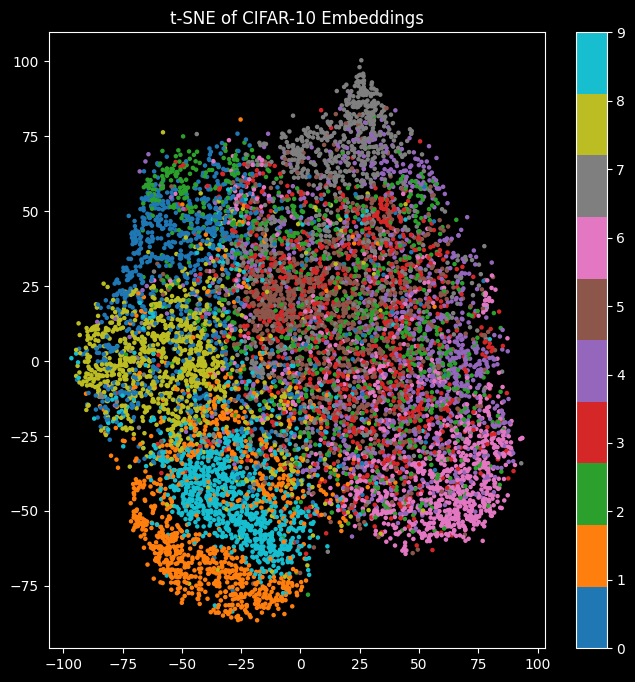

In [96]:
tsne_gpu = cuTSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=5000,
    verbose=1
)
X_2d_gpu = tsne_gpu.fit_transform(X_gpu)

X_2d = cp.asnumpy(X_2d_gpu)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=5, cmap="tab10")
plt.colorbar(scatter)
plt.title("t-SNE of CIFAR-10 Embeddings")
plt.show()

[2025-11-19 12:50:32.087] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')
[2025-11-19 12:50:32.088] [CUML] [debug] Computing KNN Graph
[2025-11-19 12:50:32.257] [CUML] [debug] Computing fuzzy simplicial set


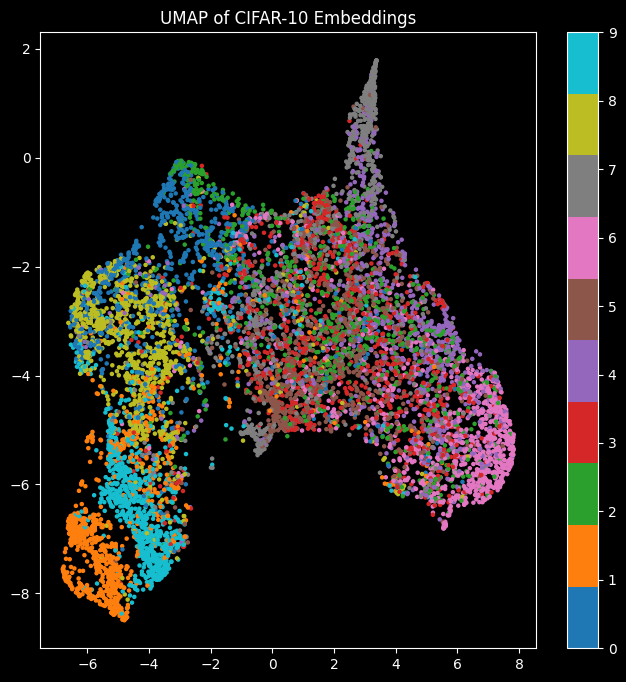

In [94]:
umap_gpu = cuUMAP(
    n_components=2,
    n_neighbors=45,
    n_epochs=1000,
    metric="euclidean",
    verbose=True,
    negative_sample_rate=10,
    min_dist=0.001,
)
X_umap_gpu = umap_gpu.fit_transform(X_gpu)
X_umap = cp.asnumpy(X_umap_gpu)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=5, cmap="tab10")
plt.colorbar(scatter)
plt.title("UMAP of CIFAR-10 Embeddings")
plt.show()

In [98]:
import plotly.express as px
import pandas as pd

# umap3d = cuUMAP(
#     n_components=3,
#     n_neighbors=15,
#     min_dist=0.1,
#     metric="euclidean",
#     verbose=True,
# )

umap3d = cuUMAP(
    n_components=3,
    n_epochs=1000,
    metric="euclidean",
    verbose=True,
    min_dist=0.01
)

X_umap_gpu = umap3d.fit_transform(X_gpu)
X_umap = cp.asnumpy(X_umap_gpu)

df_umap = pd.DataFrame({
    "x": X_umap[:, 0],
    "y": X_umap[:, 1],
    "z": X_umap[:, 2],
    "label": labels
})

fig_umap = px.scatter_3d(
    df_umap,
    x="x", y="y", z="z",
    color="label",
    opacity=0.75,
    title="3D UMAP of CIFAR-10 Embeddings",
    color_continuous_scale="Rainbow"
)
fig_umap.update_traces(marker=dict(size=3))
fig_umap.update_layout(template="plotly_dark")
fig_umap.show()

[2025-11-19 13:00:40.402] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')
[2025-11-19 13:00:40.404] [CUML] [debug] Computing KNN Graph
[2025-11-19 13:00:40.560] [CUML] [debug] Computing fuzzy simplicial set


In [57]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, output=10):
        super().__init__()

        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False

        self.classifier = nn.Linear(512, output)

    def forward(self, x):
        with torch.no_grad():
            feat = self.encoder(x)
        return self.classifier(feat)

    def train(self, mode=True):
        super().train(mode)
        self.encoder.eval()

In [ ]:
class_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                std=[0.2470, 0.2435, 0.2616]),
])

epochs = 100

linear_classifier = LinearClassifier(simclr.encoder).to(device)
sc = GradScaler(device=device)

opt = torch.optim.SGD(
    [p for p in linear_classifier.parameters() if p.requires_grad],
    lr=0.1*(batch_size/256),
    momentum=0.9,
    weight_decay=0,
    nesterov=True
)

sch = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt,
    T_max=epochs,
    eta_min=0
)

criterion = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    linear_classifier.train()
    total_loss = total_samples = correct = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch', leave=False)

    for images, labels in loop:
        images, labels = class_transforms(images).to(device), labels.to(device)
        opt.zero_grad(set_to_none=True)

        with autocast(device_type=device):
            logits = linear_classifier(images)
            loss = criterion(logits, labels)

        sc.scale(loss).backward()
        sc.unscale_(opt)
        sc.step(opt)
        sc.update()

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": correct / labels.size(0)
        })

    print(f"Epoch {epoch+1}:\nLoss: {total_loss/total_samples}\nAcc: {correct/total_samples}\n")
    sch.step()

In [ ]:
linear_classifier.eval()

total_loss = total_samples = correct = 0

for images, labels in validate_loader:
    images, labels = normalize(images).to(device), labels.to(device)

    with torch.no_grad():
      with autocast(device_type=device):
          logits = linear_classifier(images)
          loss = criterion(logits, labels)

    total_loss += loss.item() * labels.size(0)
    total_samples += labels.size(0)
    preds = torch.argmax(logits, dim=1)
    correct += (preds == labels).sum().item()

print(f"Test\nLoss: {total_loss/total_samples}\nAcc: {correct/total_samples}\n")